# Machine Learning model to predict credit risk

## Part 1: Exploratory Data Analysis and Data Preprocessing

In [7]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


# filter warnings
import warnings
warnings.filterwarnings('ignore')

# seaborn grid style
sns.set_theme(style='whitegrid')

In [8]:
# loading the data in a dataframe
df = pd.read_csv("german_credit_data.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


The dataset exhibits some quality issues, including missing values in the Saving accounts and Checking account columns, which may impact the reliability of credit risk assessments.

In [10]:
df.shape

(1000, 10)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


The dataset contains 1,000 entries with 10 columns, but it has significant missing values in the Saving accounts (183 missing) and Checking account (394 missing) columns, while all other columns are fully populated.

In [13]:
#summary statistics for the data
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


For the purpose of classification, we will be Good Risk as 0 and Bad Risk as 1. Female will be 0 and Male will be 1

In [15]:
#Target and Sex to be treated as binary
#Target will be labelled as 0 for good risk and 1 for bad risk
#Male will be 1 and Female will be 0
df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

In [16]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Splitting data into training and test data

In [18]:
#used stratify to ensure proportionality of classes in 'y' is maintained in training and test data
y = df['Risk'].copy()
X = df.drop(columns=['Risk'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify=y,random_state=42) 

In [19]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (800, 9).
Train target dataset shape: (800,).
Test predictor dataset shape: (200, 9).
Test target dataset shape: (200,).


In [20]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64

Test target proportion: 
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64


In [21]:
#understanding feature matrix
train = pd.concat([X_train,y_train],axis=1)
train.head()
numerical_features = X_train.select_dtypes('number').columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()
target = 'Risk'
print(f'There are {len(numerical_features)} numerical features: ')
print(numerical_features)
print(f'\nThere are {len(categorical_features)} categorical features: ')
print(categorical_features)
print(f'\nThe target feature is: {target}')

There are 5 numerical features: 
['Age', 'Sex', 'Job', 'Credit amount', 'Duration']

There are 4 categorical features: 
['Housing', 'Saving accounts', 'Checking account', 'Purpose']

The target feature is: Risk


In [22]:
for feature in categorical_features:
    print(feature)
    print(f'There are {train[feature].nunique()} unique values. They are: ')
    print(train[feature].value_counts(normalize=True))
    print()

Housing
There are 3 unique values. They are: 
Housing
own     0.7125
rent    0.1800
free    0.1075
Name: proportion, dtype: float64

Saving accounts
There are 4 unique values. They are: 
Saving accounts
little        0.724085
moderate      0.137195
quite rich    0.076220
rich          0.062500
Name: proportion, dtype: float64

Checking account
There are 3 unique values. They are: 
Checking account
little      0.452479
moderate    0.442149
rich        0.105372
Name: proportion, dtype: float64

Purpose
There are 8 unique values. They are: 
Purpose
car                    0.34750
radio/TV               0.26875
furniture/equipment    0.18625
business               0.09875
education              0.05625
repairs                0.02250
domestic appliances    0.01250
vacation/others        0.00750
Name: proportion, dtype: float64



Decision on type of encoding the categorical features:
- For ordinal data type, we choose original encoder. Thus, savings and checking accounts would fall in that category
- For cardinal data type, we choose target encoder

### Univariate Analysis

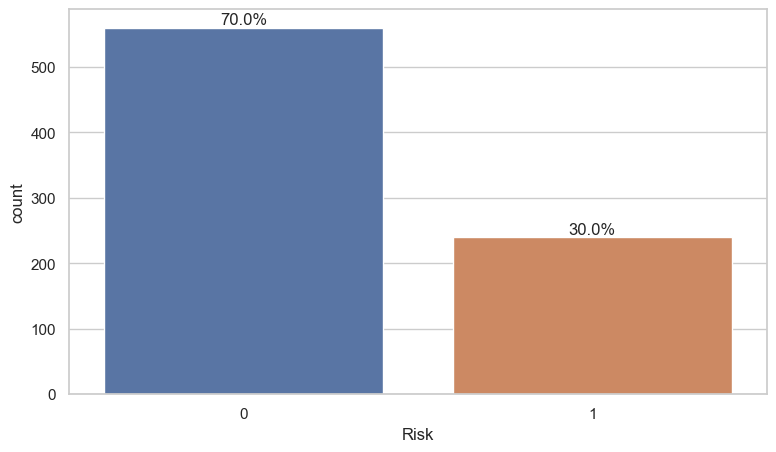

In [25]:
#visualization of target distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=train, x='Risk')

total = len(train)
counts = [count.get_height() for count in ax.patches]
percentages = [(count / total) * 100 for count in counts]

for count, percentage in zip(ax.patches, percentages):
    x = count.get_x() + count.get_width() / 2 
    y = count.get_height()
    ax.annotate(f'{percentage:.1f}%', (x, y), ha='center', va='bottom')
plt.show()

The target variable is somewhat imbalanced, with 30% of customers classified as bad risk. Given that there are only 1,000 rows of data, several strategies will be implemented to address this issue:
- Stratified Hold-Out and K-Fold Cross-Validation: These methods will be used to ensure that the target class proportions are preserved in both the test and validation sets, even during hyperparameter tuning.
- Class Weights Adjustment: Different weights will be assigned to the majority and minority class instances, with higher weights given to the minority class. This approach will penalize the model more for incorrectly classifying bad risk customers, and these weights will be set using model-specific hyperparameters.

### Numerical feature distribution

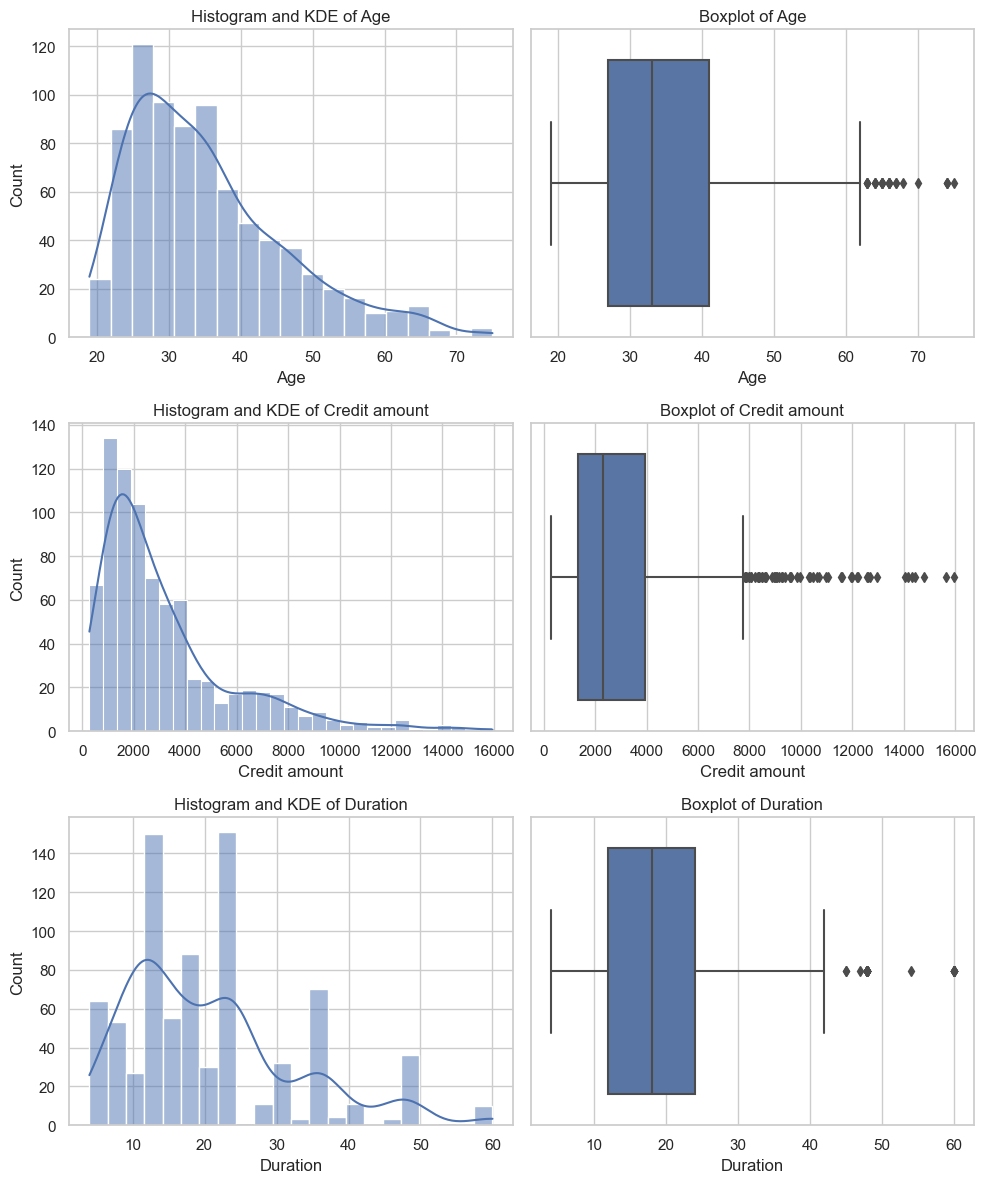

In [28]:
histplot_boxplot_features = ['Age', 'Credit amount', 'Duration']

# Create subplots
fig, axes = plt.subplots(nrows=len(histplot_boxplot_features), ncols=2, figsize=
                         (10, 4 * len(histplot_boxplot_features)))

# Loop through each feature to create histograms and boxplots
for i, feature in enumerate(histplot_boxplot_features):
    # Histogram with KDE
    sns.histplot(data=train, x=feature, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram and KDE of {feature}')
    
    # Boxplot
    sns.boxplot(data=train, x=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {feature}')

# Adjust layout
plt.tight_layout()
plt.show()

- Most of the customers are between 20 and 40 years old.
- Distribution of credit amounts is skewed to the right. Most customers have low credit amounts, while there are some outliers with very high credit balances.
- A significant portion of the customers stay for either 12 or 24 months while using the bank's credit service.

### Identifying Outliers

In [31]:
# Function to calculate outliers
def calculate_outliers(df, features):
    outlier_counts = {}
    total_outliers = 0

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        outlier_count = len(outliers)
        total_outliers += outlier_count
        
        # Calculate percentage
        percentage = (outlier_count / len(df)) * 100
        outlier_counts[feature] = (outlier_count, percentage)

    return total_outliers, outlier_counts

# Features to analyze
features = ['Age', 'Credit amount', 'Duration']

# Calculate outliers
total_outliers, outlier_counts = calculate_outliers(train, features)

# Output results
print(f"There are {total_outliers} outliers in the dataset.\n")
print("Number (percentage) of outliers per feature:\n")
for feature, (count, percentage) in outlier_counts.items():
    print(f"{feature}: {count} ({percentage:.2f})%")


There are 133 outliers in the dataset.

Number (percentage) of outliers per feature:

Age: 25 (3.12)%
Credit amount: 58 (7.25)%
Duration: 50 (6.25)%


The outliers don't represent inconsistent information. Some customers will have a higher credit amount, be older and have stayed longer with the bank.

### Categorical features distributions

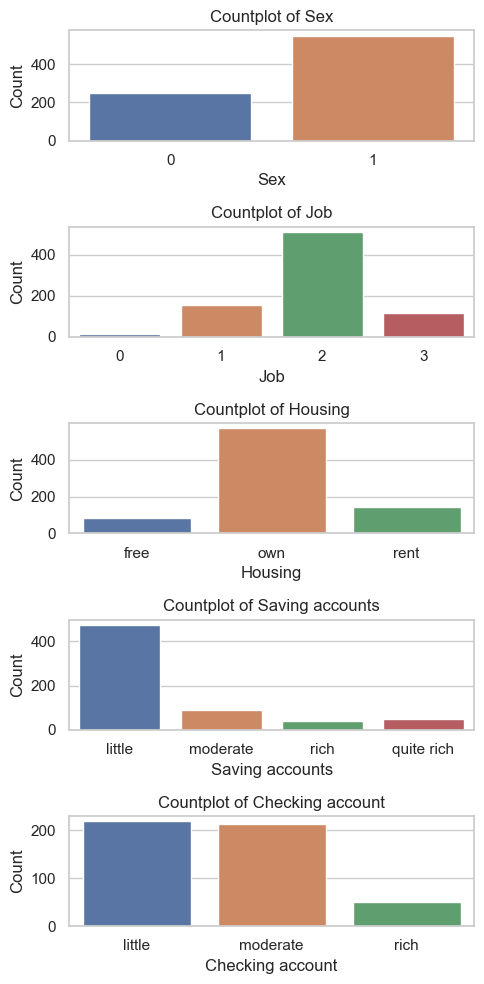

In [34]:
def sns_plots(data, features):
    # Create subplots with 1 column
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(5, 2 * len(features)))

    for i, feature in enumerate(features):
        # Countplot for each feature
        sns.countplot(data=data, x=feature, ax=axes[i])
        axes[i].set_title(f'Countplot of {feature}')
        axes[i].set_ylabel('Count')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
countplot_barplot_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account']
sns_plots(data=train, features=countplot_barplot_features)

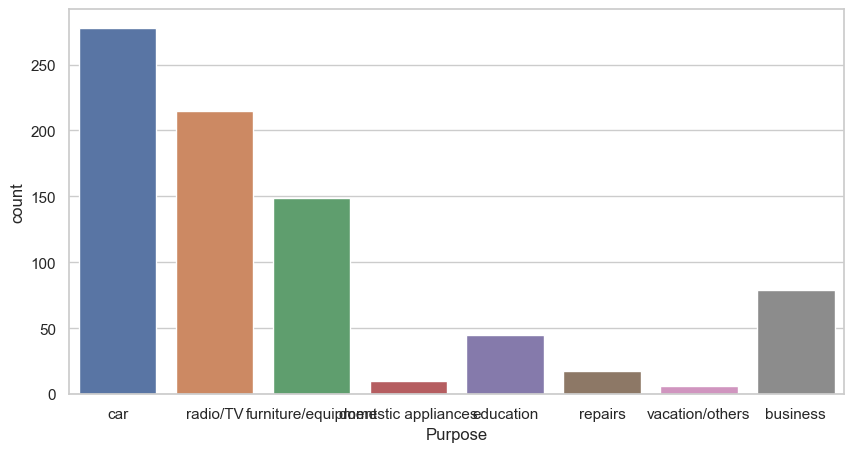

In [35]:
# Plotting purpose separately
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=train, x='Purpose')
plt.show()

### Bivariate & multivariate analysis

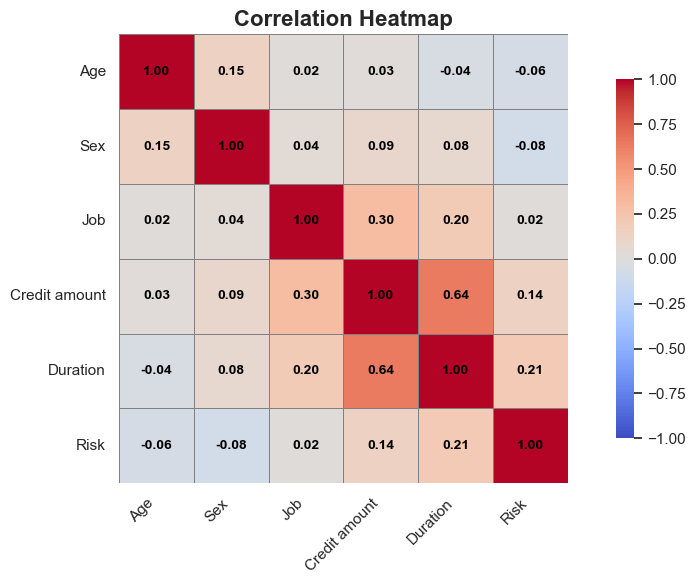

In [37]:
corr_matrix = train.corr(numeric_only=True)
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a heatmap 
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",  # Format the annotations to 2 decimal places
    cmap='coolwarm',  # Choose a color palette
    square=True,  # Make cells square-shaped
    linewidths=0.5,  # Add lines between cells
    linecolor='gray',  # Color of the lines
    cbar_kws={"shrink": .8},  # Adjust color bar size
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  # Customize annotation text
)

# Set title and labels
plt.title('Correlation Heatmap', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

- Credit amount and Duration are weakly positively correlated with the target. It makes sense because higher credit amounts tend to be associated with longer credit service durations, thus indicating a higher level of risk.
- Duration and credit amount are strongly positively correlated. Thus, when the duration of a credit service (such as a loan) is longer, the associated credit amount is generally higher.
- Credit amount and Job are moderately positively correlated. Thus, customers with more skilled jobs tend to have higher credit amounts.

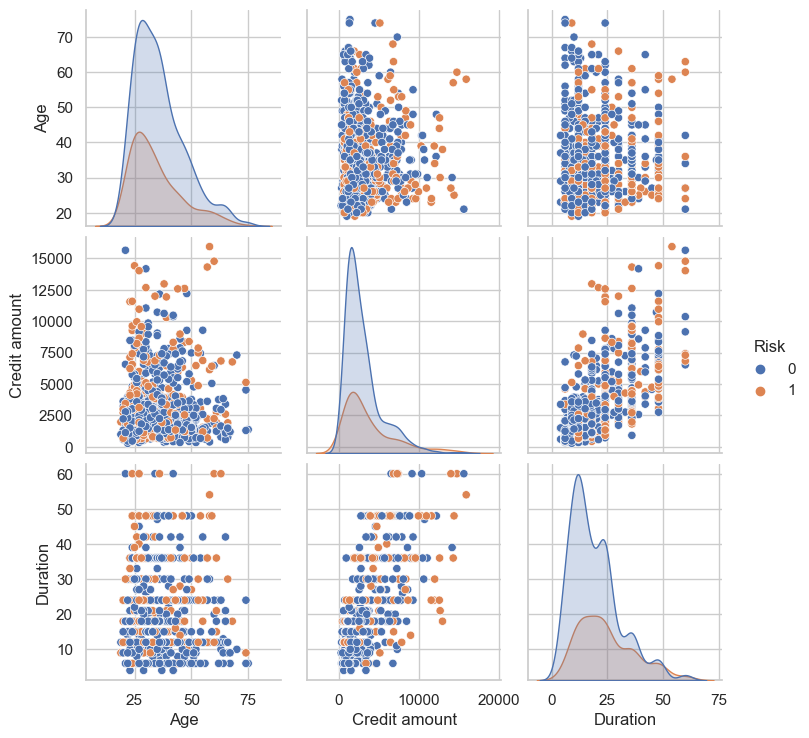

In [39]:
sns.pairplot(data=train, hue='Risk', vars=histplot_boxplot_features)
plt.show()

### Numerical features vs Risk

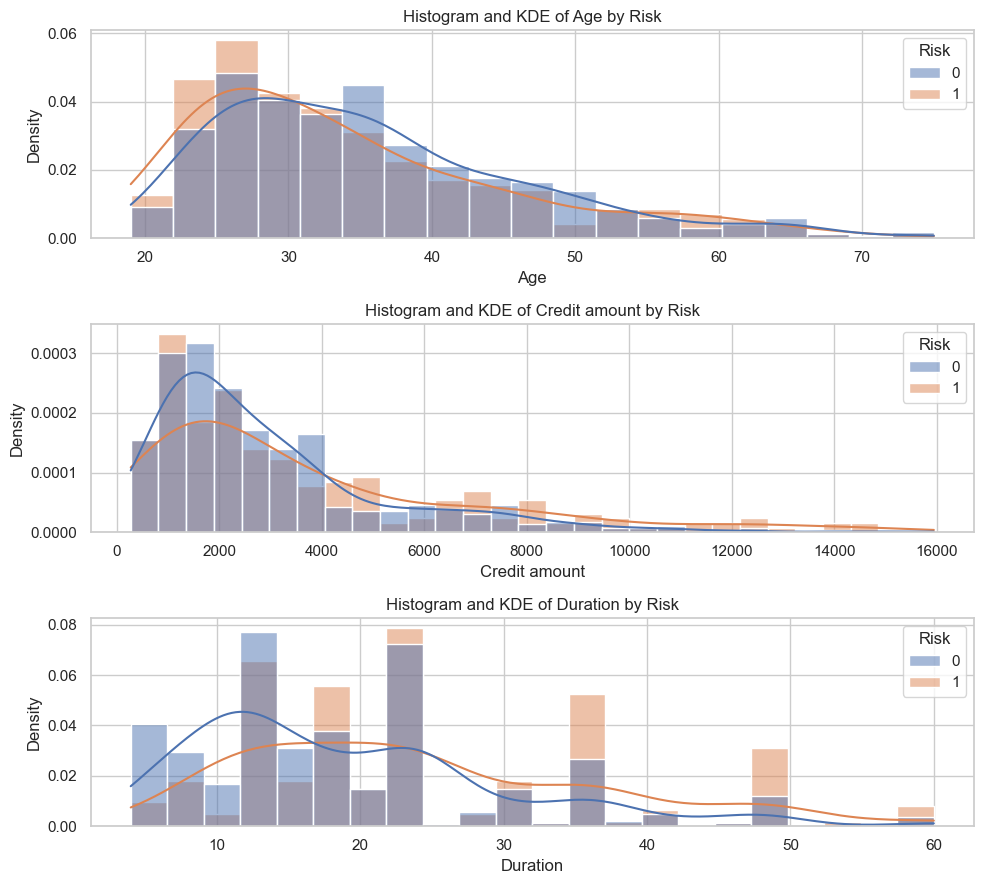

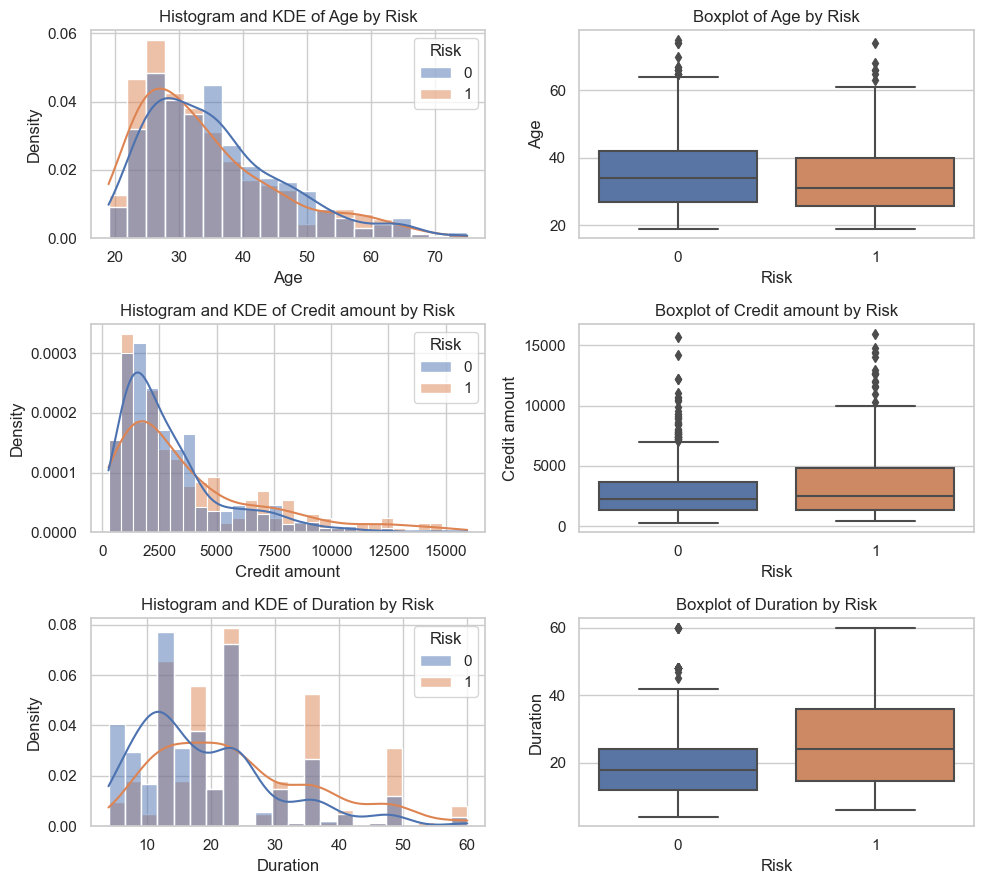

In [41]:
def sns_plots(data, features, target, histplot=True, kde=True, boxplot=False, boxplot_x=None):
    # Create subplots with 2 columns if boxplot is True, otherwise 1 column
    ncols = 2 if boxplot else 1
    fig, axes = plt.subplots(nrows=len(features), ncols=ncols, figsize=(10, 3 * len(features)))

    for i, feature in enumerate(features):
        # Histogram with KDE
        if histplot:
            ax = axes[i, 0] if boxplot else axes[i]  # Correctly index axes
            sns.histplot(data=data, x=feature, hue=target, kde=kde, ax=ax, stat="density", common_norm=False)
            ax.set_title(f'Histogram and KDE of {feature} by {target}')
            ax.set_ylabel('Density')
        
        # Boxplot
        if boxplot:
            ax = axes[i, 1]  # Correctly index axes for boxplot
            sns.boxplot(data=data, x=boxplot_x, y=feature, ax=ax)
            ax.set_title(f'Boxplot of {feature} by {boxplot_x}')
            ax.set_ylabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
histplot_boxplot_features = ['Age', 'Credit amount', 'Duration']
target = 'Risk'  # Replace with your actual target variable

# Call for histogram and KDE plots
sns_plots(data=train, features=histplot_boxplot_features, target=target, histplot=True, kde=True)

# Call for boxplots
sns_plots(data=train, features=histplot_boxplot_features, target=target, boxplot=True, boxplot_x=target)

- Bad risk customers are slightly younger compared to good risk ones. This may be due to lack of financial stability in young people.
- Bad risk customers tend to borrow higher credit amounts compared to good risk ones. This was expected since higher credit amounts present higher levels of risk.
- Bad risk customers tend to use credit services for longer durations compared to good risk ones. This was expected because, as seen above, when the duration of a credit service (such as a loan) is longer, the associated credit amount is generally higher and thus the levels of risk are so.

### Categorical Features vs Risk

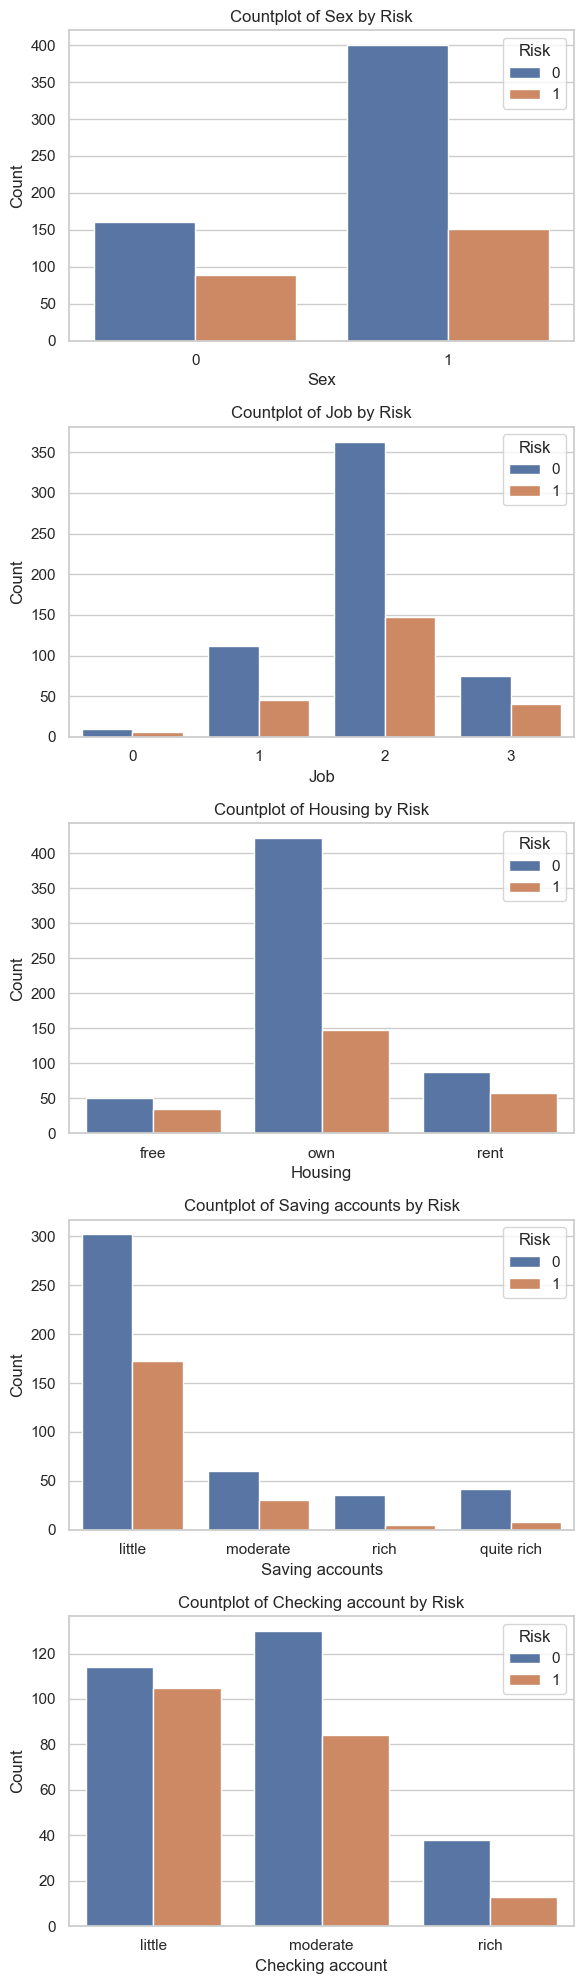

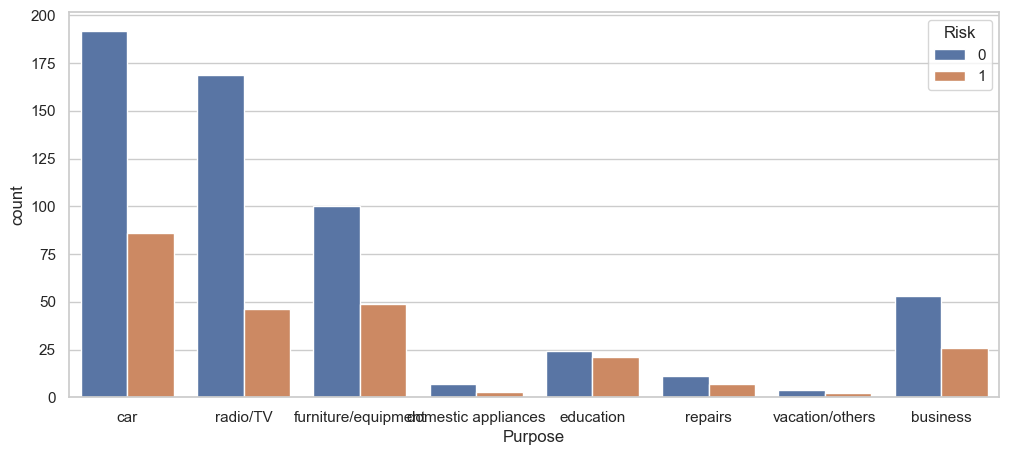

In [44]:
def sns_countplots(data, features, target):
    # Create subplots with 1 column for each feature
    n_features = len(features)
    fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(6, 4 * n_features))

    for i, feature in enumerate(features):
        # Create countplot for each feature
        sns.countplot(data=data, x=feature, hue=target, ax=axes[i])
        axes[i].set_title(f'Countplot of {feature} by {target}')
        axes[i].set_ylabel('Count')
        axes[i].legend(title='Risk', loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
countplot_barplot_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account']
target = 'Risk'  # Replace with your actual target variable
sns_countplots(data=train, features=countplot_barplot_features, target=target)

# Plotting Purpose split
plt.figure(figsize=(12, 5))
sns.countplot(data=train, x='Purpose', hue='Risk')
plt.show()

- The proportion of bad risk is higher among female customers, with approximately 36% classified as bad risk, compared to 27% for male customers.
- Similarly, customers living in free or rented housing exhibit a higher bad risk proportion, around 40%, while this figure drops to 26% for those who own their homes.
- Customers with little or moderate savings accounts tend to show higher risk levels. In contrast, those with rich or quite rich savings accounts demonstrate lower risk. This could be due to clients with substantial savings being better positioned to manage their credit obligations compared to those with lower balances.
- The same trend is observed with checking accounts, particularly with nearly 50% of customers having little in their checking accounts classified as bad risk. This is a significant concern for the bank.
- Almost 50% of customers who took out loans for educational purposes are also categorized as bad risk.

### Categorical features vs Credit Amount

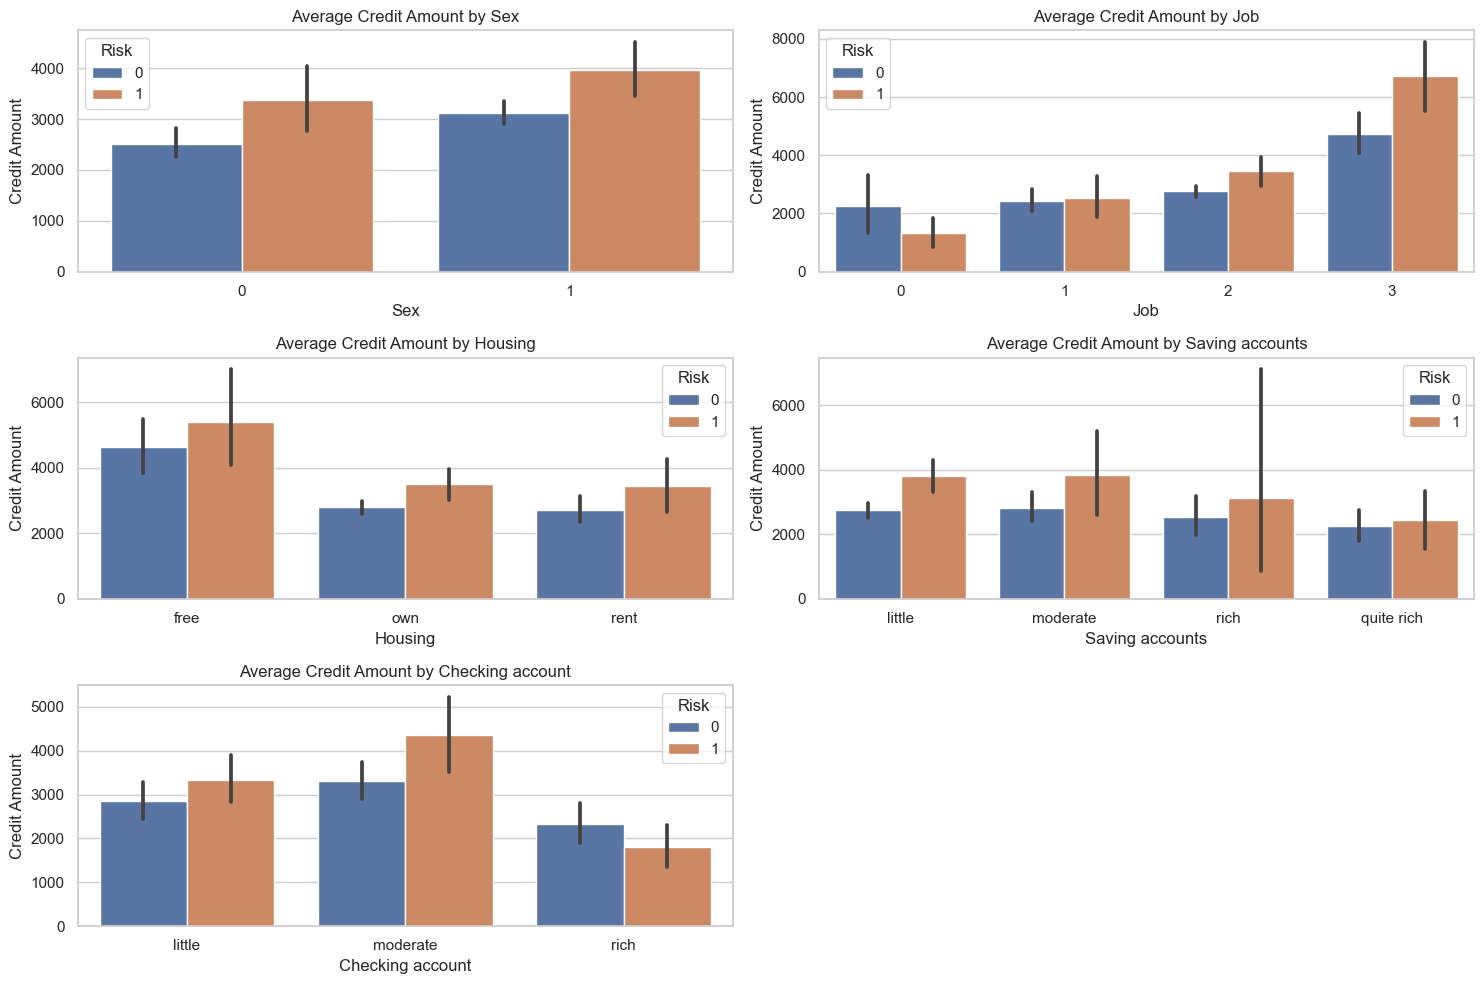

In [47]:
'''Examine relationships among some features and Credit amount to see which are the characteristics of customers 
who take (on average) higher credit amounts and may present higher levels of risk'''

def sns_barplots(data, features, target):
    # Create subplots with 2 columns
    n_features = len(features)
    fig, axes = plt.subplots(nrows=(n_features + 1) // 2, ncols=2, figsize=(15, 10))

    for i, feature in enumerate(features):
        ax = axes[i // 2, i % 2]  # Determine the correct subplot
        sns.barplot(data=data, x=feature, y='Credit amount', hue=target, ax=ax, ci=95) 
        ax.set_title(f'Average Credit Amount by {feature}')
        ax.set_ylabel('Credit Amount')
        ax.set_xlabel(feature)
        ax.legend(title='Risk')

    # Hide any empty subplots
    if n_features % 2 != 0:
        axes[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account']
target = 'Risk'  # Replace with your actual target variable
sns_barplots(data=train, features=features, target=target)

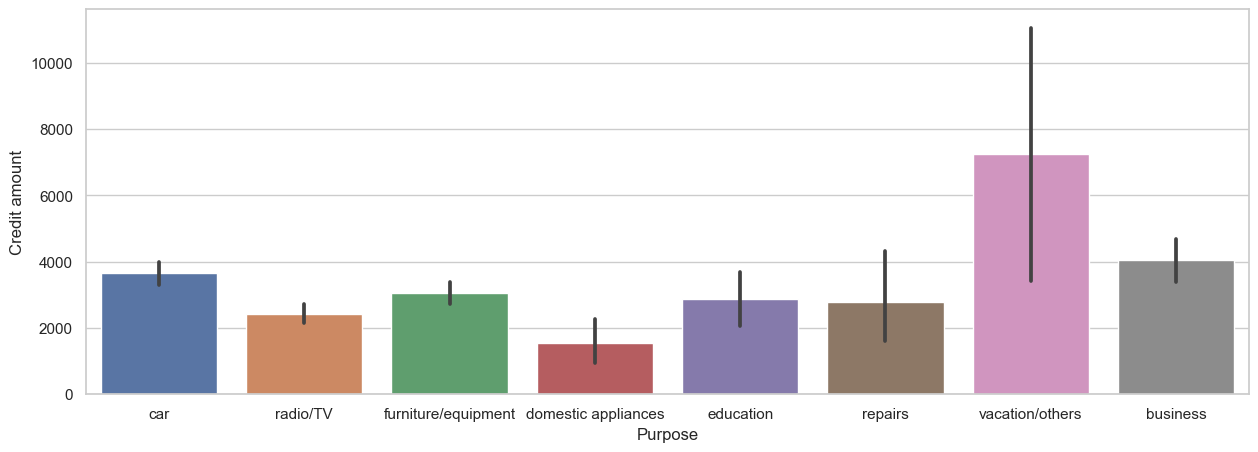

In [48]:
# Plotting Purpose split
plt.figure(figsize=(15, 5))
sns.barplot(data=train, x='Purpose', y='Credit amount')
plt.show()

- Customers who hold highly skilled jobs borrow higher 
- Customers within free housing category borrow higher
- Customers who took credit for vacation/others purpose borrowed higher

### Categorical features vs Duration

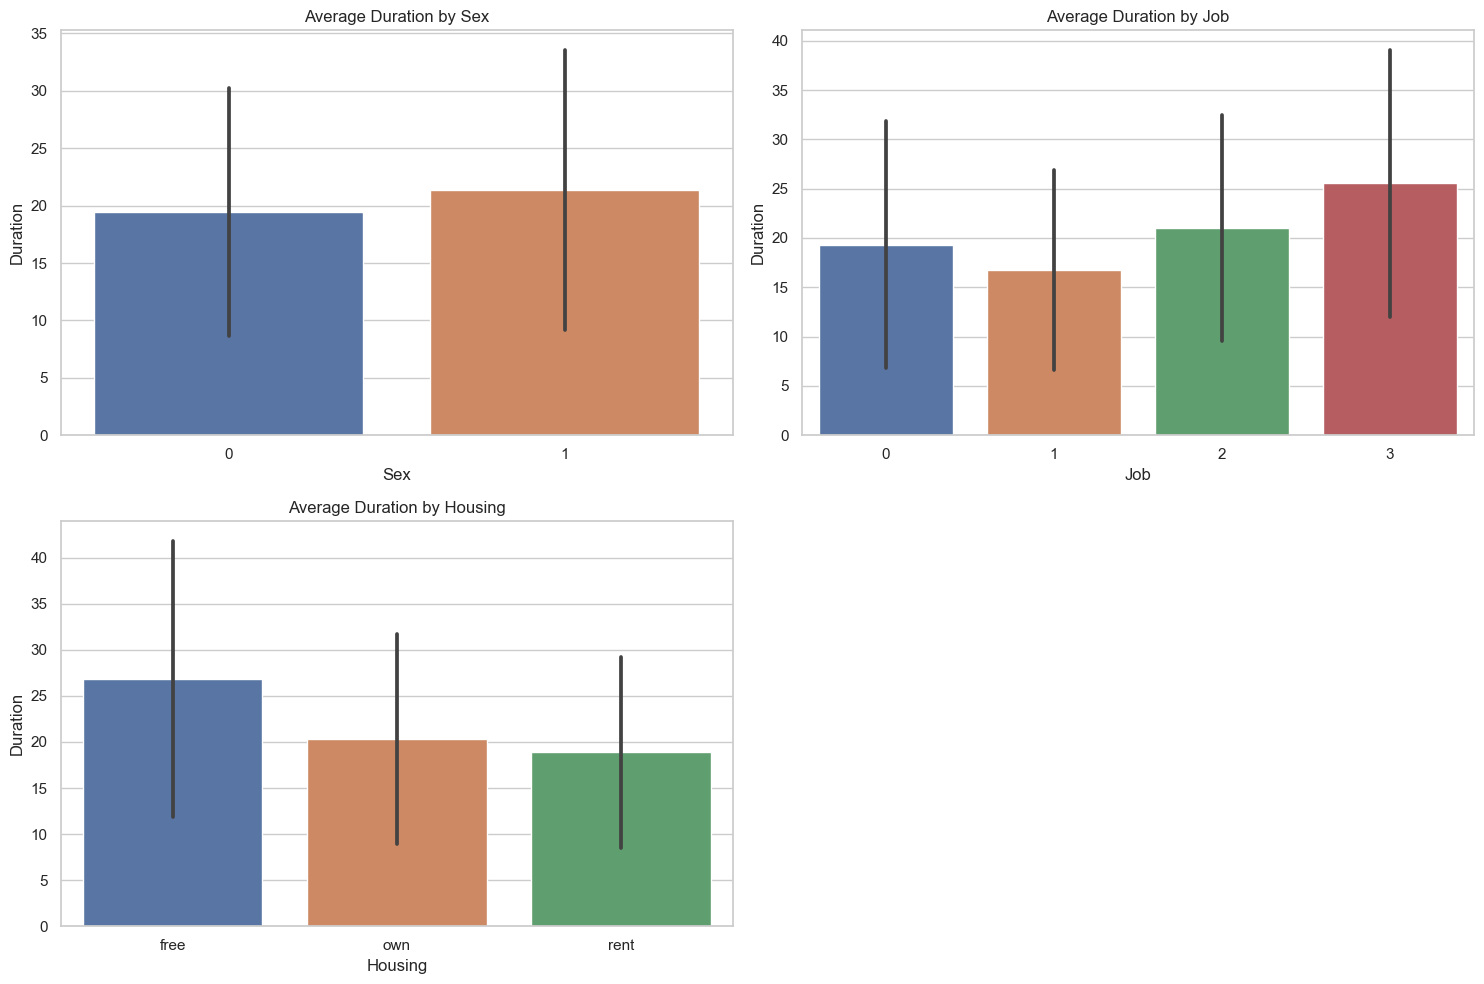

In [51]:
'''examine relationships among some features and Duration below in order to see which are the characteristics
of customers who take credit services with longer durations and consequently present higher levels of risk'''
def sns_plots(data, features, barplot_y, barplot=True):
    # Create subplots with 2 columns
    n_features = len(features)
    fig, axes = plt.subplots(nrows=(n_features + 1) // 2, ncols=2, figsize=(15, 10))

    for i, feature in enumerate(features):
        ax = axes[i // 2, i % 2]  # Determine the correct subplot
        if barplot:
            sns.barplot(data=data, x=feature, y=barplot_y, ax=ax, ci='sd')  # Standard deviation for error bars
            ax.set_title(f'Average {barplot_y} by {feature}')
            ax.set_ylabel(barplot_y)
            ax.set_xlabel(feature)

    # Hide any empty subplots
    if n_features % 2 != 0:
        axes[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
countplot_barplot_features = ['Sex', 'Job', 'Housing']  # Add your features here
barplot_y = 'Duration'  # The variable to plot on the y-axis
sns_plots(data=train, features=countplot_barplot_features, barplot_y=barplot_y)

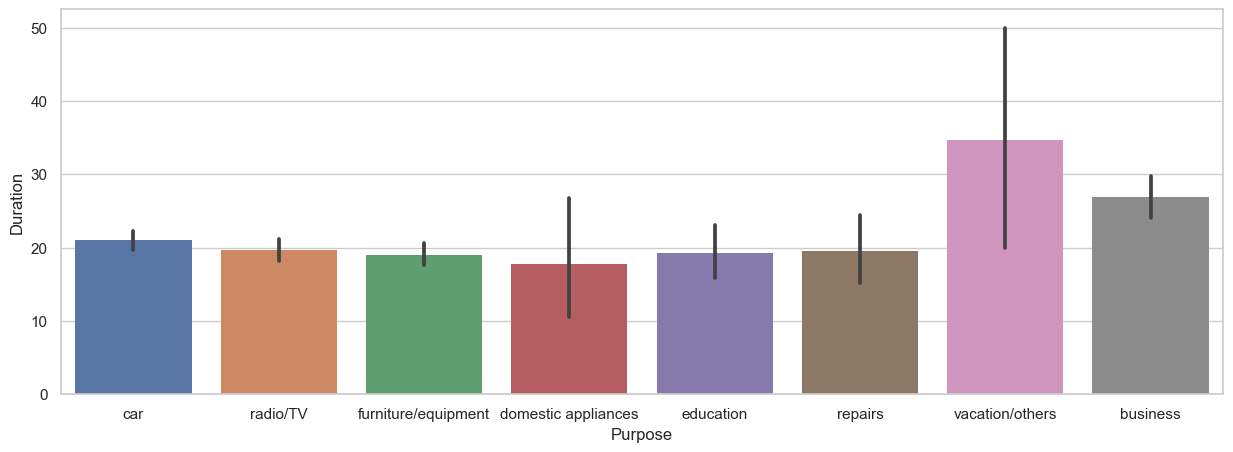

In [52]:
# Plotting Purpose separately.
plt.figure(figsize=(15, 5))
sns.barplot(data=train, x='Purpose', y='Duration', linewidth=0)
plt.show()

- Similar patterns found for average credit amount are present here. This was expected, since credit amount and duration are strongly positively correlated.
- Customers who hold highly skilled jobs, free housing, and took credit for vacation/others purpose use longer duration credit services.

### Credit duration and Risk

In [55]:
amount_duration_risk = train.groupby(['Risk'],as_index=False).agg({'Credit amount':'sum','Duration':'mean'})
amount_duration_risk['Percent'] = amount_duration_risk['Credit amount']/amount_duration_risk['Credit amount'].sum()
amount_duration_risk

,Risk,Credit amount,Duration,Percent
0,0,1650236,19.175000,0.646727
1,1,901437,24.491667,0.353273


Bad risk customers have a higher duration while a lower proportion of overall credit amount

### Clustering

For further analysis, we will use Clustering. Clustering is a machine learning technique that groups similar data points together based on their features, helping to identify patterns and structures within the data. It is essential for tasks like customer segmentation, anomaly detection, and data summarization, with common types including K-means, hierarchical clustering, and DBSCAN.

For our purpose, we will use K-Means algorithm. This will partition the data into 'k' different clusters by iteratively assigning data points to the nearest cluster centroid and updating the centroids based on the assigned points. 

There are two methods for determining the optimal number of clusters/centroids: Elbow method and Silhoutte Score. The Elbow Method is a technique used to determine the optimal number of clusters in K-means by plotting the explained variance (or within-cluster sum of squares) against the number of clusters and identifying the "elbow" point where the rate of decrease sharply changes. The Silhouette Score measures how similar an object is to its own cluster compared to other clusters, providing a value between -1 and 1 to assess the quality of clustering, with higher scores indicating better-defined clusters. 

Since our analysis is more for visualization, we will use Elbow Method 

### Age vs Duration clustering

In [60]:
# Getting inertias of different number of clusters using K-Means models
clustering_df = train[['Age', 'Duration']]
different_k_kmeans = [KMeans(n_clusters=k, random_state=42).fit(clustering_df) for k in range(1, 6)]
inertias = [model.inertia_ for model in different_k_kmeans]

In [61]:
inertias

[209056.82875,
 133297.97271160033,
 76993.37018217621,
 60921.12382970503,
 50436.35436392551]

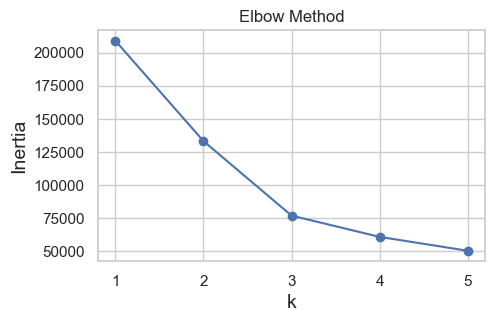

In [62]:
plt.figure(figsize=(5, 3))
plt.title('Elbow Method')
plt.plot(range(1, 6), inertias, 'bo-')
plt.xlabel('k', fontsize=14)
plt.xticks(range(1, 6))
plt.ylabel('Inertia', fontsize=14)
plt.show()

Optimal number of clusters is 3

In [64]:
# Applying K-Means clustering with the optimal number of clusters.

k_means = KMeans(n_clusters=3)
k_means.fit(clustering_df)

KMeans(n_clusters=3)

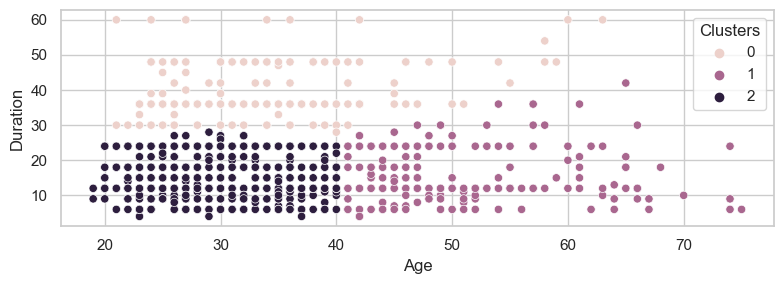

In [65]:
# Plotting the clustering result

clustering_df['Clusters'] = k_means.labels_ #assigning cluster labels generated by the K-means algorithm to the dataframe

plt.figure(figsize=(8, 3))
sns.scatterplot(data=clustering_df, x='Age', y='Duration', hue='Clusters')
plt.tight_layout()
plt.show()

Group 0: Older customers (from 40 to 70 years old) that take credit services with short durations (from 10 to 30 months).
Group 1: Young customers (from 20 to 40 years old) that take credit services with short durations (from 10 to 30 months).
Group 2: Customers who take credit services with longer durations. These customers might be people that represent a high level of risk and take credit for purposes like vacation/others.

### Credit amount vs Duration

In [68]:
clustering_df = train[['Credit amount','Duration']]
different_k_means = [KMeans(n_clusters=k,random_state=42).fit(clustering_df) for k in range(1,6)]
inertias = [model.inertia_ for model in different_k_means]

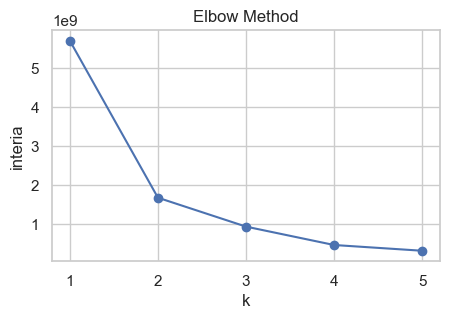

In [69]:
# plotting the curve for Elbow Method
plt.figure(figsize = (5,3))
plt.title('Elbow Method')
plt.plot(range(1,6),inertias,'bo-')
plt.xlabel('k')
plt.xticks(range(1,6))
plt.ylabel('interia')
plt.show()

Optimal number of clusters is 2

In [71]:
k_means = KMeans(n_clusters=2)
k_means.fit(clustering_df)

KMeans(n_clusters=2)

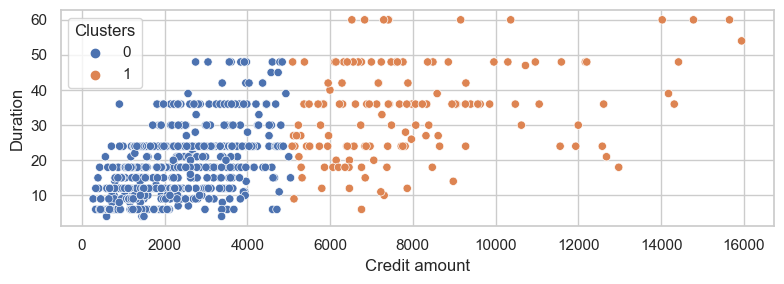

In [72]:
#plotting the clusters
clustering_df['Clusters'] = k_means.labels_ #assigning cluster labels generated by the K-means algorithm to the dataframe

plt.figure(figsize=(8, 3))
sns.scatterplot(data=clustering_df, x='Credit amount', y='Duration', hue='Clusters')
plt.tight_layout()
plt.show()

Group 0: Customers who take lower credit amounts from the bank (from 0 to 5000) with various durations (from 0 to 50 months).
Group 1: Customers who take higher credit amounts from the bank (from 5000 to 16000) with various durations (from 0 to 60 months). The credit services with longer durations were taken by this group.

Summary of Exploratory Data Analysis:
- Younger customers generally exhibit a higher credit risk, which is understandable as they often lack financial stability.
- Customers who borrow larger amounts from the bank typically pose a greater risk. This is logical, as larger loans can be more challenging to repay.
- Customers utilizing credit services for extended periods are associated with higher risk. The longer a customer uses a credit service without repayment, the greater the likelihood of default.
- There is a strong positive correlation between credit amount and duration. Credit services with longer terms are usually linked to higher credit amounts, and vice versa. Additionally, a weak positive correlation exists between these two factors and risk, as customers with longer credit service durations and larger amounts tend to present a higher risk.

## Part 2: Building model

The main parts of modeling would include data preprocessing, model training, model comparison and selection, final model testing and evaluation

In [77]:
#installing required libraries
#!pip install category_encoders
#!pip install xgboost
#!pip install scikit-optimize
#!pip install scikit-optimize

In [78]:
#importing libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve

import time

# Fixing bayesian search error
np.int = int

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

In [79]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,NaN,little,1169,6,radio/TV,0
1,22,0,2,own,little,moderate,5951,48,radio/TV,1
2,49,1,1,own,little,NaN,2096,12,education,0
3,45,1,2,free,little,little,7882,42,furniture/equipment,0
4,53,1,2,free,little,little,4870,24,car,1


In [80]:
#printing shapes of training and test data to confirm
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (800, 9).
Train target dataset shape: (800,).
Test predictor dataset shape: (200, 9).
Test target dataset shape: (200,).


### Data Cleaning and preprocessing

Following steps are being done to clean the data
- Impute missing values: Missing values in Purpose and Housing accounts will be replaced by most frequent and Savings and Checking will be replaced by Median
- Outliers are being treated as part of the features and hence not being omitted
- Will be applying standard scaling on numerical and categorical features, post encoding
- For Savings and Checking accounts, OrdinalEncoder will be used
- TargetEncoder will be used for Purpose and Housing to avoid dimensionality increase associated with OneHotEncoder.

In [83]:
#building the preprocessor
target_encoder_features = ['Saving accounts','Checking account']
ordinal_encoder_features = ['Purpose','Housing']

ordinal_pipeline = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder()),
        ('std_scaler',StandardScaler())
    ]
)
target_pipeline = Pipeline(
    steps=[
        ('target_encoder', TargetEncoder()),
        ('std_scaler',StandardScaler())
    ]
)
preprocessor = ColumnTransformer(
    transformers = [
        ('ordinal',ordinal_pipeline,ordinal_encoder_features),
        ('target', target_pipeline,target_encoder_features),
        ('std_scaler', StandardScaler(), numerical_features)
    ], remainder = 'passthrough'
)
X_train_prepared = preprocessor.fit_transform(X_train,y_train)
X_train_prepared.shape

(800, 9)

### Model training and comparison

Now we will use stratified k-fold cross validation for training the model and evaluate using ROC-AUC score.
K-fold cross-validation helps evaluate how well a model generalizes to an independent dataset. By splitting the data into K subsets (or folds), the model is trained on K−1 folds and tested on the remaining fold. This process is repeated K times, with each fold serving as the test set once.
The model with highest ROC-AUC validation scores and acceptable bias-variance trade-off will be selected.
Post that, hyperparameter tuning will be done. Hyperparameter tuning refers to the process of selecting the optimal hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the model is trained and directly influence its performance but are not learned from the data.


In [86]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Neural Network': MLPClassifier(max_iter=2000)
}

In [87]:
import pandas as pd
def evaluate_models(models, X_train, y_train):
    """
    Evaluate multiple models using cross-validation and return their performance metrics.

    Parameters:
    models (dict): A dictionary of model names and their corresponding model instances.
    X_train (DataFrame): The training features.
    y_train (Series): The target labels.

    Returns:
    None: Prints the evaluation results for each model.
    """
    
    results = [] #for storing the results
    
    for model_name, model in models.items():
        # Start the timer
        start_time = time.time()
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Calculate training score
        training_score = model.score(X_train, y_train)
        
        # Perform cross-validation and calculate the ROC-AUC score
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        
        # Calculate average validation score and standard deviation
        average_validation_score = scores.mean()
        std_deviation = scores.std()
        
        # Calculate training time
        training_time = time.time() - start_time
        
        # Store the results in the list
        results.append({
            'Model': model_name,
            'Training Score': training_score,
            'Average Validation Score': average_validation_score,
            'Standard Deviation': std_deviation,
            'Training Time (s)': training_time
        })
        
        # Print the results in the desired format
        print(f"{model_name} results: ")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"Training score: {training_score:.6f}")
        print(f"Average validation score: {average_validation_score:.6f}")
        print(f"Standard deviation: {std_deviation:.6f}")
        print(f"Training time: {training_time:.5f} seconds\n")
        
    return results
        

In [88]:
result_df = pd.DataFrame(evaluate_models(models=models, X_train=X_train_prepared, y_train=y_train))

Logistic Regression results: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training score: 0.748750
Average validation score: 0.755990
Standard deviation: 0.022612
Training time: 0.03747 seconds

Linear SVM results: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training score: 0.748750
Average validation score: 0.755394
Standard deviation: 0.024254
Training time: 0.10781 seconds

SVM results: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training score: 0.791250
Average validation score: 0.736012
Standard deviation: 0.039426
Training time: 0.12906 seconds

K-Nearest Neighbors results: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training score: 0.816250
Average validation score: 0.657626
Standard deviation: 0.037916
Training time: 0.06033 seconds

Random Forest results: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training score: 1.000000
Average validation score: 0.725763
Standard deviation: 0.019981
Training time: 1.03700 seconds

XGBoost results: 
~~~~~~~~~~~~~~~~~~~~~~~

In [89]:
result_df.sort_values(['Average Validation Score'],ascending = False)

,Model,Training Score,Average Validation Score,Standard Deviation,Training Time (s)
0,Logistic Regression,0.74875,0.755990,0.022612,0.037465
1,Linear SVM,0.74875,0.755394,0.024254,0.107813
2,SVM,0.79125,0.736012,0.039426,0.129063
4,Random Forest,1.00000,0.725763,0.019981,1.036998
5,XGBoost,1.00000,0.716629,0.027146,0.315566
6,Neural Network,0.95500,0.693452,0.029654,23.520633
3,K-Nearest Neighbors,0.81625,0.657626,0.037916,0.060327


Random Forest and XGBoost show signs of overfitting, as they achieve perfect training scores but lower validation scores. This means they may not perform well on unseen data.
Logistic Regression and Linear SVM provide a good balance between training and validation scores, making them potentially better choices for this task.
The Neural Network takes significantly longer to train compared to other models.

### Hyperparameter tuning

In [92]:
#Bayesian Optimization for hyperparamter tuning on Random Forest model
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(10, 100), #reduced to increase speed
    'criterion': Categorical(['gini', 'entropy']), #removed log_loss to increase speed
    'max_depth': Integer(2, 10), #reduced to increase speed
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(2, 25),
    'bootstrap': Categorical([True, False]),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'max_features': Categorical(['sqrt', 'log2', None])
}

bayesian_search = BayesSearchCV(estimator=RandomForestClassifier(), 
                                search_spaces=search_space, 
                                cv=stratified_kfold, 
                                n_iter=10, #reduced to increase speed
                                scoring='roc_auc', 
                                return_train_score=True, 
                                random_state=42)

In [93]:
bayesian_search.fit(X_train_prepared, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(), n_iter=10, random_state=42,
              return_train_score=True, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'class_weight': Categorical(categories=('balanced', 'balanced_subsample'), prior=None),
                             'criterion': Ca...
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=2, high=25, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=100, prior='uniform', transform='normalize')})

In [94]:
print(f'The best params fund for Random Forest are: ')
bayesian_search.best_params_

The best params fund for Random Forest are: 


OrderedDict([('bootstrap', True),
             ('class_weight', 'balanced_subsample'),
             ('criterion', 'gini'),
             ('max_depth', 5),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 12),
             ('min_samples_split', 9),
             ('n_estimators', 78)])

In [95]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score', 'mean_test_score', 
                                                    'mean_train_score', 'param_class_weight', 
                                                    'param_criterion', 'param_max_depth', 
                                                    'param_min_samples_leaf', 'param_min_samples_split', 
                                                    'param_n_estimators']]

top_rf_results = bayesian_search_results.sort_values(['rank_test_score']).head(10)
top_rf_results.head(10)

,rank_test_score,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators
2,1,0.766034,0.841441,balanced_subsample,gini,5,12,9,78
0,2,0.760268,0.852895,balanced_subsample,entropy,5,12,19,77
9,3,0.759654,0.828946,balanced_subsample,entropy,4,8,17,24
6,4,0.756436,0.877367,balanced_subsample,gini,9,16,33,48
8,5,0.754818,0.869169,balanced_subsample,entropy,5,7,2,43
3,6,0.753534,0.907142,balanced,entropy,8,4,38,89
7,7,0.744792,0.925330,balanced_subsample,gini,9,3,29,12
5,8,0.720685,0.792504,balanced_subsample,gini,4,11,24,58
4,9,0.704948,0.836702,balanced,entropy,8,18,22,69
1,10,0.677604,0.937409,balanced_subsample,gini,10,3,9,42


In [96]:
# Bayesian Optimization for hyperparameter tuning on Logistic Regression model
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Define the search space
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization strength
    'solver': Categorical(['liblinear', 'saga']),  # Solver type
    'penalty': Categorical(['l1', 'l2']),  # Type of regularization
    'max_iter': Integer(100, 500)  # Maximum number of iterations
}

# Create the BayesSearchCV object
bayesian_search_logreg = BayesSearchCV(
    estimator=LogisticRegression(),
    search_spaces=search_space,
    cv=stratified_kfold,
    n_iter=50,
    scoring='roc_auc',
    return_train_score=True,
    random_state=42
)


# Fit the model
try:
    bayesian_search_logreg.fit(X_train_prepared, y_train)
except ValueError as e:
    print(f"Error during fitting: {e}")

In [97]:
# Output the best parameters and score
best_params = bayesian_search_logreg.best_params_
best_logreg_model = bayesian_search_logreg.best_estimator_ #retrieving the best LogReg model
print("Best parameters found: ", best_params)
print("Best score: ", bayesian_search_logreg.best_score_)

Best parameters found:  OrderedDict([('C', 0.10081366593556343), ('max_iter', 500), ('penalty', 'l1'), ('solver', 'saga')])
Best score:  0.758891369047619


In [98]:
bayesian_search_results_logreg = pd.DataFrame(bayesian_search_logreg.cv_results_)

bayesian_search_results_logreg = bayesian_search_results_logreg[['rank_test_score', 'mean_test_score', 
                                                    'mean_train_score', 'param_C', 
                                                    'param_solver', 'param_penalty', 
                                                    'param_max_iter']]

# Sort the results by rank_test_score and display the top 10 results
top_logreg_results = bayesian_search_results_logreg.sort_values(['rank_test_score']).head(10)
top_logreg_results.head(10)

,rank_test_score,mean_test_score,mean_train_score,param_C,param_solver,param_penalty,param_max_iter
40,1,0.758891,0.762237,0.100814,saga,l1,500
37,2,0.758538,0.761665,0.091276,saga,l1,121
2,3,0.757217,0.763951,0.217766,liblinear,l1,467
34,4,0.757106,0.764495,0.482226,saga,l1,497
25,5,0.756548,0.764628,0.653227,liblinear,l1,100
43,6,0.756324,0.764423,0.293168,liblinear,l2,500
7,7,0.756287,0.764662,3.317698,saga,l1,468
0,8,0.756250,0.764156,0.083416,liblinear,l2,391
26,9,0.756213,0.764569,0.694127,saga,l2,100
20,10,0.756101,0.764576,1000000.0,saga,l2,100


### Comparing the models


Model Comparison:
                 Model  Best Mean Test Score  Best Mean Train Score  \
0  Logistic Regression              0.758891               0.762237   
1        Random Forest              0.766034               0.841441   

   Overfitting  
0     0.003346  
1     0.075407  


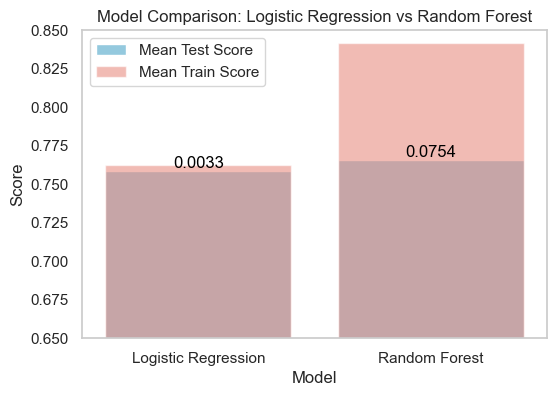

In [100]:
best_logreg = top_logreg_results.iloc[0]
best_rf = top_rf_results.iloc[0]

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Best Mean Test Score': [best_logreg['mean_test_score'], best_rf['mean_test_score']],
    'Best Mean Train Score': [best_logreg['mean_train_score'], best_rf['mean_train_score']],
})

# Calculate Overfitting
comparison_df['Overfitting'] = comparison_df['Best Mean Train Score'] - comparison_df['Best Mean Test Score']

# Display the comparison DataFrame
print("\nModel Comparison:")
print(comparison_df)

# Step 4: Plotting the results
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Best Mean Test Score', data=comparison_df, color='skyblue', label='Mean Test Score')
sns.barplot(x='Model', y='Best Mean Train Score', data=comparison_df, color='salmon', label='Mean Train Score', alpha=0.6)

# Adding Overfitting as a line plot
for index, row in comparison_df.iterrows():
    plt.text(index, row['Best Mean Test Score'] + 0.002, f"{row['Overfitting']:.4f}", color='black', ha='center')

plt.title('Model Comparison: Logistic Regression vs Random Forest')
plt.ylabel('Score')
plt.legend()
plt.ylim(0.65, 0.85)
plt.grid(axis='y')
plt.show()

- The Random Forest model has a higher mean training score suggesting it fits the training data better
- The Random Forest model has a higher mean test score also compared to the Logistic Regression model, indicating that it performs better on test data
- However, the random forest model may be overfitting to some extent

In [102]:
# Stacking the models with tuned Random classifier and Logistic Regression as base learners to improve predictive performance
tuned_rf_model = RandomForestClassifier(**bayesian_search.best_params_)  # Use the best parameters from tuning

# Define base learners
base_learners = [
    ('rf', tuned_rf_model),
    ('lr', LogisticRegression())
]

# Define the stacking classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Fit the stacking model
stacking_model.fit(X_train_prepared, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=5,
                                                       min_samples_leaf=12,
                                                       min_samples_split=9,
                                                       n_estimators=78)),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [103]:
# Comparing the Stacked model with the individual model performance metrics

stacked_model_score = stacking_model.score(X_train_prepared, y_train) 
stacked_test_score = stacked_model_score  

# Create a comparison DataFrame including the stacked model
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Stacked Model'],
    'Best Mean Test Score': [best_logreg['mean_test_score'], best_rf['mean_test_score'], stacked_test_score],
    'Best Mean Train Score': [best_logreg['mean_train_score'], best_rf['mean_train_score'], stacked_model_score],
})

# Calculate Overfitting
comparison_df['Overfitting'] = comparison_df['Best Mean Train Score'] - comparison_df['Best Mean Test Score']

# Display the comparison DataFrame
print("\nModel Comparison:")
print(f"{'Model':<20} {'Best Mean Test Score':<25} {'Best Mean Train Score':<25} {'Overfitting':<15}")
for index, row in comparison_df.iterrows():
    print(f"{row['Model']:<20} {row['Best Mean Test Score']:<25.6f} {row['Best Mean Train Score']:<25.6f} {row['Overfitting']:<15.6f}")
    



Model Comparison:
Model                Best Mean Test Score      Best Mean Train Score     Overfitting    
Logistic Regression  0.758891                  0.762237                  0.003346       
Random Forest        0.766034                  0.841441                  0.075407       
Stacked Model        0.770000                  0.770000                  0.000000       


We notice that even with Stacking, the improvement in best mean train score is there, but the mean train score has dropped significantly and is closer to that of logistic regression. Hence, we decide to go ahead with only the Random Forest Model.

### Model Testing

In [106]:
X_test_prepared = preprocessor.transform(X_test)
X_test_prepared.shape

(200, 9)

In [107]:
tuned_rf_model.fit(X_train_prepared,y_train)
final_predictions = tuned_rf_model.predict(X_test_prepared)

In [108]:
def evaluate_classifier(y_true, y_pred):
    # Print the classification report
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

evaluate_classifier(y_test, final_predictions)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.68      0.75       140
           1       0.48      0.70      0.57        60

    accuracy                           0.69       200
   macro avg       0.66      0.69      0.66       200
weighted avg       0.73      0.69      0.70       200



Comment on Model Performance:
- Recall Score of 0.72, also known as true positive rate is the ratio that the model correctly identifies. This means the model correctly identifies 72% of the bad risk customers. There is room to increase the recall score though
- Precision of 0.52, is the proportion of correctly predicted positive cases (bad risk customers) out of all instances predicted as positive by the model. However, predicting good risk customers as bad risk (false positive) will not harm the bank as the goals is to identify a significant portion of bad risk customers

### Precision vs Recall tradeoff improvement 

Since the objective is to correctly predict more bad risk customers, we can see if we can improve the recall without significantly hitting the Precision levels.

In [111]:
predicted_probas = tuned_rf_model.predict_proba(X_test_prepared)

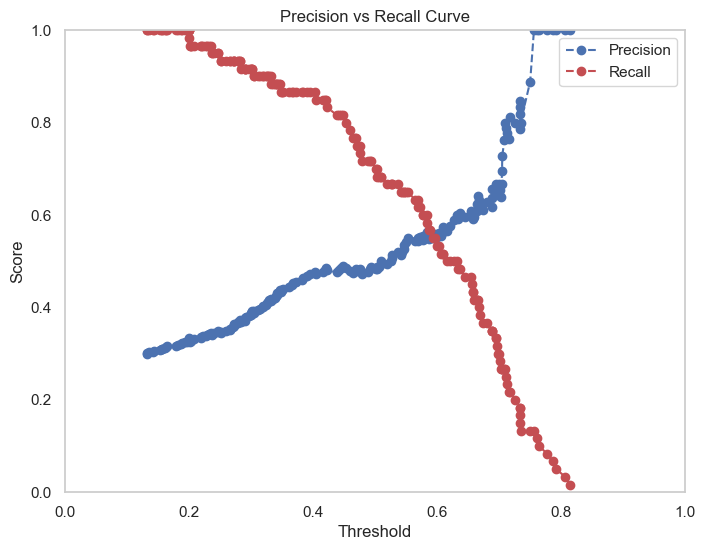

In [112]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predicted_probas[:, 1])

# Plot Precision and Recall against Thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], marker='o', linestyle='--', color='b', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', linestyle='--', color='r', label='Recall')
plt.title('Precision vs Recall Curve')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.legend(loc='best')
plt.show()

In [113]:
# Print precision and recall for a range of thresholds
for i in range(0, len(thresholds), 10):  # Adjust step size as needed
    print(f"Threshold: {thresholds[i]:.2f}, Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}")

Threshold: 0.13, Precision: 0.30, Recall: 1.00
Threshold: 0.16, Precision: 0.32, Recall: 1.00
Threshold: 0.20, Precision: 0.33, Recall: 1.00
Threshold: 0.23, Precision: 0.34, Recall: 0.97
Threshold: 0.26, Precision: 0.35, Recall: 0.93
Threshold: 0.28, Precision: 0.37, Recall: 0.93
Threshold: 0.30, Precision: 0.39, Recall: 0.92
Threshold: 0.33, Precision: 0.42, Recall: 0.90
Threshold: 0.35, Precision: 0.43, Recall: 0.87
Threshold: 0.40, Precision: 0.47, Recall: 0.87
Threshold: 0.45, Precision: 0.49, Recall: 0.82
Threshold: 0.49, Precision: 0.48, Recall: 0.72
Threshold: 0.53, Precision: 0.50, Recall: 0.67
Threshold: 0.56, Precision: 0.54, Recall: 0.63
Threshold: 0.59, Precision: 0.55, Recall: 0.55
Threshold: 0.63, Precision: 0.60, Recall: 0.50
Threshold: 0.66, Precision: 0.62, Recall: 0.42
Threshold: 0.70, Precision: 0.67, Recall: 0.33
Threshold: 0.71, Precision: 0.80, Recall: 0.27
Threshold: 0.73, Precision: 0.80, Recall: 0.13


In [114]:
selected_threshold = 0.39 #from the output table
threshold_predictions = (predicted_probas[:, 1] >= selected_threshold).astype(int)

In [115]:
evaluate_classifier(y_test, threshold_predictions)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.58      0.71       140
           1       0.47      0.87      0.61        60

    accuracy                           0.67       200
   macro avg       0.69      0.72      0.66       200
weighted avg       0.78      0.67      0.68       200



With this change, the model can correctly predict 85% of bad risk customers, with precision falling slightly to 0.47 from 0.52

In [117]:
#top 10 customers with highest estimated probabilities of bad risk
bad_risk_probas = predicted_probas[:, 1]

probas_df = pd.concat([X_test, y_test], axis=1)
probas_df['Bad Risk Probas'] = bad_risk_probas
probas_df.sort_values(['Bad Risk Probas'], ascending=False).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
832,29,1,2,rent,little,little,11816,45,business,1,0.813755
11,24,0,2,rent,little,little,4308,48,business,1,0.806771
375,37,0,2,rent,little,little,7685,48,business,1,0.792433
887,23,1,2,own,little,moderate,15672,48,business,1,0.787328
522,53,1,2,free,little,little,7119,48,furniture/equipment,1,0.777633
915,32,0,3,own,little,moderate,18424,48,vacation/others,1,0.764684
831,23,0,2,rent,little,little,1216,18,car,1,0.760617
570,23,0,1,rent,little,little,3234,24,furniture/equipment,1,0.756361
818,43,1,3,own,little,little,15857,36,vacation/others,0,0.750280
43,24,1,2,rent,moderate,little,6187,30,car,0,0.734785


In [118]:
#top 10 customers with lowest estimated probabilities of bad risk
probas_df.sort_values(['Bad Risk Probas'], ascending=True).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
551,45,1,1,own,quite rich,NaN,1750,6,radio/TV,0,0.131545
473,36,1,3,own,NaN,NaN,1238,6,education,0,0.132038
947,38,1,3,own,NaN,NaN,2859,12,car,0,0.135103
234,42,1,1,own,little,NaN,1544,4,radio/TV,0,0.141199
159,34,1,1,own,NaN,NaN,1898,6,radio/TV,0,0.144143
682,33,1,2,own,little,NaN,1478,15,radio/TV,0,0.152842
681,37,1,2,free,NaN,NaN,2279,12,radio/TV,0,0.156123
283,63,1,2,own,NaN,NaN,1520,15,furniture/equipment,0,0.156887
514,54,1,2,own,NaN,NaN,2255,24,car,0,0.160779
6,53,1,2,own,quite rich,NaN,2835,24,furniture/equipment,0,0.162233


### Conclusion

In this project, I developed a Random Forest Classifier to predict credit risk for customers of a German bank. The main goal was to accurately identify high-risk customers, focusing on maximizing recall.
The model successfully predicts 85% of high-risk customers. The exploratory data analysis (EDA) provided valuable insights into credit risk patterns.
To address the imbalanced target, I used stratified splitting, stratified k-fold cross-validation, adjusted class weights, and balanced the precision-recall trade-off.
Initially, I achieved a recall score of 0.72 through hyperparameter tuning. By adjusting the threshold, I increased recall to 0.85 while reducing precision around 0.47.